<a href="https://colab.research.google.com/github/btcnhung1299/tf-practice/blob/master/TS_SunspotForecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data Gathering

In [ ]:
!wget https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv

--2020-09-29 13:42:49--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.188.128, 64.233.189.128, 108.177.97.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.188.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘Sunspots.csv.3’

Sunspots.csv.3      100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2020-09-29 13:42:49 (81.0 MB/s) - ‘Sunspots.csv.3’ saved [70827/70827]



In [ ]:
df = pd.read_csv("Sunspots.csv", index_col=0)
df.head()

Date  Monthly Mean Total Sunspot Number
0  1749-01-31                               96.7
1  1749-02-28                              104.3
2  1749-03-31                              116.7
3  1749-04-30                               92.8
4  1749-05-31                              141.7

## Data Preprocessing & Batchifying

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data = df["Monthly Mean Total Sunspot Number"].values.reshape(-1, 1)
data = scaler.fit_transform(data)

<Figure size 360x432 with 0 Axes>

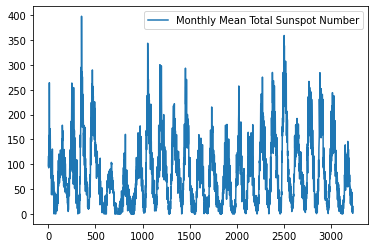

In [ ]:
fig = plt.figure(figsize=(5, 6));
df.plot();

### Multi-output forecasting w. single step model

Predict multiple next values at once.

In [ ]:
BUFFER_SIZE = 1024
WINDOW_SIZE = 60

samples = tf.data.Dataset.from_tensor_slices(data)
samples = samples.window(size=WINDOW_SIZE + 1, shift=1, drop_remainder=True).flat_map(lambda w : w.batch(WINDOW_SIZE + 1))
samples = samples.map(lambda x : (tf.expand_dims(x[:-1], axis=-1), x[1:]))
samples = samples.shuffle(BUFFER_SIZE)

In [ ]:
BATCH_SIZE = 64

test_size = 0.2
num_samples = sum(1 for x in samples)
num_train_samples = int((1 - test_size) * num_samples)
print("Number of training samples:", num_train_samples)
print("Number of validation samples:", num_samples - num_train_samples)
ds_train = samples.take(num_train_samples).batch(BATCH_SIZE)
ds_val = samples.skip(num_train_samples).batch(BATCH_SIZE)

Number of training samples: 2540
Number of validation samples: 635


## Model Architecture

### Stacked RNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, Conv1D, LSTM, Dense, GRU

In [ ]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", activation="relu", input_shape=[WINDOW_SIZE, 1]))
model.add(GRU(128, return_sequences=True))
model.add(GRU(64, return_sequences=True))
model.add(Dense(32, activation="swish"))
model.add(Dense(16, activation="swish"))
model.add(Dense(1))

In [ ]:
model.compile(optimizer="rmsprop", loss="huber", metrics=["mae"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 60, 32)            192       
_________________________________________________________________
gru (GRU)                    (None, 60, 128)           62208     
_________________________________________________________________
gru_1 (GRU)                  (None, 60, 64)            37248     
_________________________________________________________________
dense (Dense)                (None, 60, 32)            2080      
_________________________________________________________________
dense_1 (Dense)              (None, 60, 16)            528       
_________________________________________________________________
dense_2 (Dense)              (None, 60, 1)             17        
Total params: 102,273
Trainable params: 102,273
Non-trainable params: 0
__________________________________________________

In [ ]:
model.fit(ds_train, epochs=40, validation_data=ds_val);

Epoch 1/40
40/40 [==============================] - 3s 76ms/step - loss: 0.0061 - mae: 0.0779 - val_loss: 0.0045 - val_mae: 0.0655
Epoch 2/40
40/40 [==============================] - 2s 57ms/step - loss: 0.0032 - mae: 0.0576 - val_loss: 0.0045 - val_mae: 0.0676
Epoch 3/40
40/40 [==============================] - 2s 57ms/step - loss: 0.0027 - mae: 0.0535 - val_loss: 0.0024 - val_mae: 0.0490
Epoch 4/40
40/40 [==============================] - 3s 63ms/step - loss: 0.0024 - mae: 0.0502 - val_loss: 0.0026 - val_mae: 0.0541
Epoch 5/40
40/40 [==============================] - 3s 66ms/step - loss: 0.0024 - mae: 0.0499 - val_loss: 0.0020 - val_mae: 0.0458
Epoch 6/40
40/40 [==============================] - 2s 62ms/step - loss: 0.0024 - mae: 0.0494 - val_loss: 0.0025 - val_mae: 0.0492
Epoch 7/40
40/40 [==============================] - 3s 67ms/step - loss: 0.0023 - mae: 0.0485 - val_loss: 0.0026 - val_mae: 0.0543
Epoch 8/40
40/40 [==============================] - 2s 60ms/step - loss: 0.0023 - m

### Bidirectional RNN

In [ ]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", activation="relu", input_shape=[WINDOW_SIZE, 1]))
model.add(Bidirectional(GRU(64, return_sequences=True)))
model.add(Bidirectional(GRU(64, return_sequences=True)))
model.add(Dense(32, activation="swish"))
model.add(Dense(16, activation="swish"))
model.add(Dense(1))

model.compile(optimizer="rmsprop", loss="huber", metrics=["mae"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 60, 32)            192       
_________________________________________________________________
bidirectional (Bidirectional (None, 60, 128)           37632     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 60, 128)           74496     
_________________________________________________________________
dense_3 (Dense)              (None, 60, 32)            4128      
_________________________________________________________________
dense_4 (Dense)              (None, 60, 16)            528       
_________________________________________________________________
dense_5 (Dense)              (None, 60, 1)             17        
Total params: 116,993
Trainable params: 116,993
Non-trainable params: 0
________________________________________________

In [ ]:
model.fit(ds_train, epochs=20, validation_data=ds_val);

Epoch 1/20
40/40 [==============================] - 5s 123ms/step - loss: 0.0043 - mae: 0.0635 - val_loss: 0.0020 - val_mae: 0.0430
Epoch 2/20
40/40 [==============================] - 4s 92ms/step - loss: 0.0022 - mae: 0.0464 - val_loss: 0.0016 - val_mae: 0.0390
Epoch 3/20
40/40 [==============================] - 3s 86ms/step - loss: 0.0017 - mae: 0.0411 - val_loss: 0.0014 - val_mae: 0.0372
Epoch 4/20
40/40 [==============================] - 3s 87ms/step - loss: 0.0014 - mae: 0.0378 - val_loss: 0.0012 - val_mae: 0.0357
Epoch 5/20
40/40 [==============================] - 4s 89ms/step - loss: 0.0010 - mae: 0.0328 - val_loss: 7.6570e-04 - val_mae: 0.0296
Epoch 6/20
40/40 [==============================] - 4s 88ms/step - loss: 7.3047e-04 - mae: 0.0285 - val_loss: 4.2442e-04 - val_mae: 0.0226
Epoch 7/20
40/40 [==============================] - 4s 91ms/step - loss: 5.2845e-04 - mae: 0.0241 - val_loss: 0.0011 - val_mae: 0.0348
Epoch 8/20
40/40 [==============================] - 4s 95ms/step -